<a href="https://colab.research.google.com/github/dansarmiento/machine_learning_notebooks/blob/main/Naive_Bayes_for_Depression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Depression with Naive Bayes

**Project Objective**

To develop a Gaussian Naive Bayes classifier that accurately predicts the likelihood of depression based on demographic, academic, and lifestyle factors. This project aims to establish a reliable baseline model for early identification and to uncover key factors associated with mental health challenges.

**Executive Summary**

This project successfully developed a machine learning model to predict depression, achieving an overall accuracy of 86% and a weighted-average F1-Score of 0.86. Exploratory data analysis (EDA) revealed that a history of suicidal thoughts, a family history of mental illness, and high levels of academic or work-related stress were the most significant predictors. The final Gaussian Naive Bayes model proves to be an effective baseline classifier, demonstrating a strong ability to identify individuals at risk of depression.

**Key Insights & Findings**

**Exploratory Data Analysis**
Analysis uncovered several powerful predictors of depression:

- Behavioral & Historical Factors: A history of suicidal thoughts and a family history of mental illness showed the strongest correlation with a positive depression diagnosis.
- Environmental Stressors: High levels of Academic Pressure, Work Pressure, and Financial Stress were all significantly correlated with a higher incidence of depression.
- Academic & Professional Life: A lower CGPA and general dissatisfaction with one's studies or job also emerged as notable contributing factors.

**Model Performance**

The Gaussian Naive Bayes model provides a solid baseline for this classification task.

- Overall Performance: The model achieved an accuracy of 86% and an F1-Score of 0.79 for the positive class, indicating it is reliable and effective.
- Predictive Strength: The model demonstrated a strong ability to correctly identify individuals with depression (True Positives), which is a critical outcome for any real-world application. The confusion matrix confirms that the model effectively captures the patterns identified during the EDA.

**Conclusion & Next Steps**

The final model is a successful proof-of-concept, demonstrating that machine learning can be effectively used to identify key factors related to depression. The 86% weighted-average F1-score confirms its reliability as a baseline model.

Potential future work could involve exploring more complex models like Random Forests or Gradient Boosting to potentially improve predictive accuracy and further validate these initial findings.

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# import the data
import re

url = 'https://docs.google.com/spreadsheets/d/1YKcR6X_aYEj5s_YABtZiUx9g_-zFJzdIBt6mbv8Uof0/edit?usp=sharing'

# Extract sheet_id using regex
match = re.search(r'/d/([a-zA-Z0-9-_]+)', url)
sheet_id = match.group(1) if match else None

sheet_name = 'train'
gsheet_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(gsheet_url)
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')

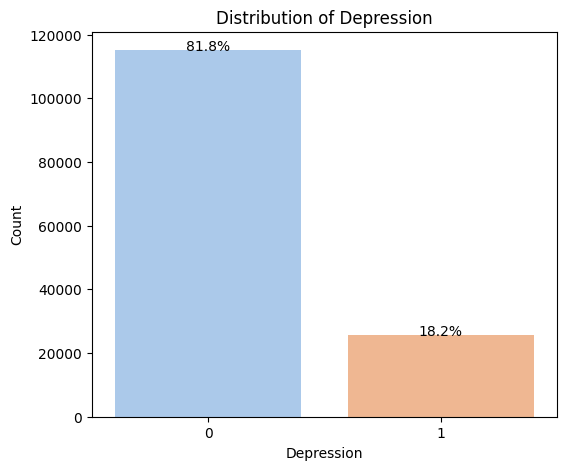

In [23]:
# Target Variable Distribution
plt.figure(figsize=(6, 5))
sns.countplot(x='depression', data=df, hue='depression', palette='pastel', legend=False)
plt.title('Distribution of Depression')
plt.xlabel('Depression')
plt.ylabel('Count')

# Calculate and display the percentage
total = len(df['depression'])
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 5,
            f'{height/total:.1%}',
            ha="center")
plt.show()

# Distributions of Numerical Features

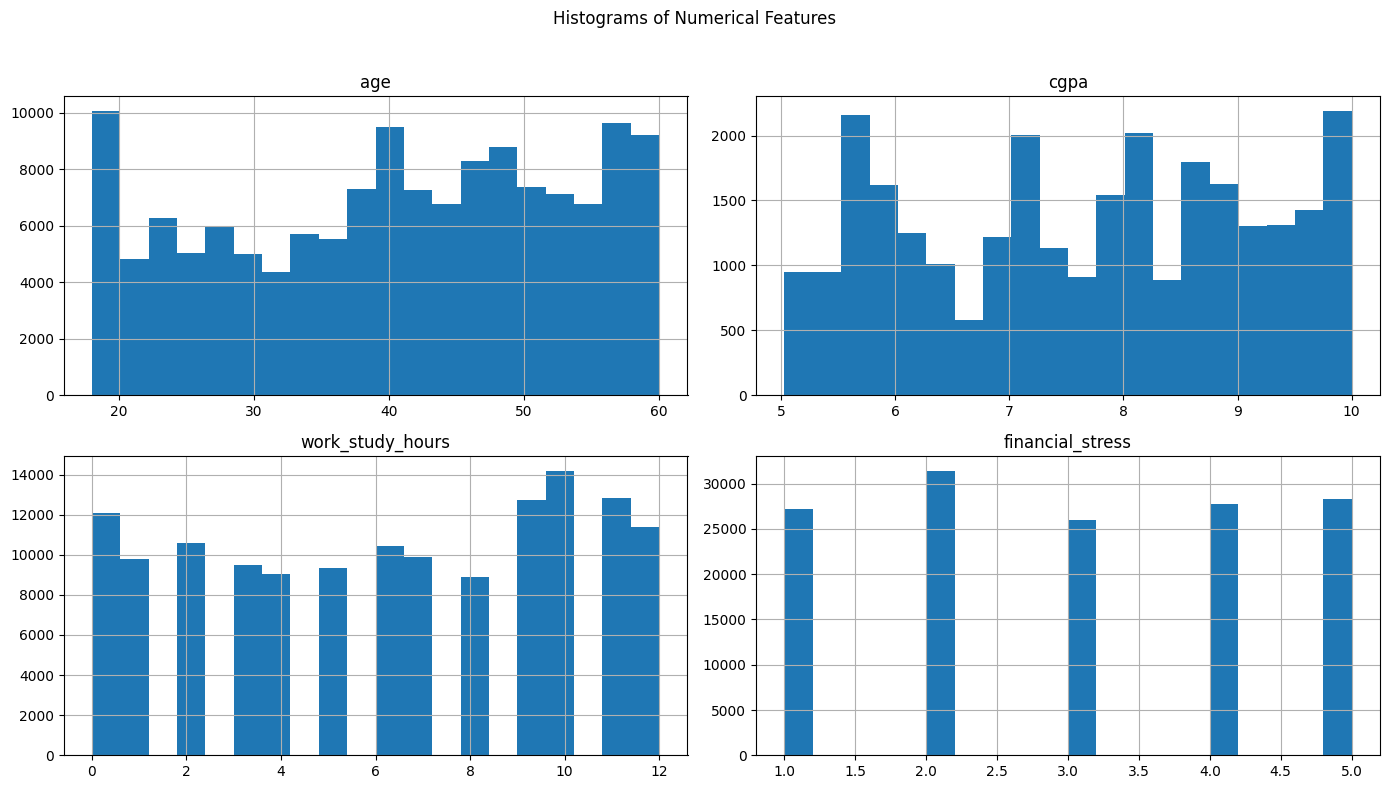

In [24]:
numerical_features = ['age', 'cgpa', 'work_study_hours', 'financial_stress']

# Histograms to see the distribution of each numerical feature
df[numerical_features].hist(bins=20, figsize=(14, 8), layout=(2, 2))
plt.suptitle('Histograms of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()


| Feature            | Distribution Shape / Characteristics                            | Interpretation / Possible Insights                              |
|--------------------|---------------------------------------------------------------|---------------------------------------------------------------|
| `age`              | Multimodal, with a large peak around 18-19 and a spread across 20-60 | The sample likely includes a large group of young students (~18) and a wide range of older adults. Possibly a mix of undergraduate and non-traditional students. |
| `cgpa`             | Fairly uniform with some peaks at whole numbers; slight increase towards higher CGPA values | CGPA is relatively evenly distributed, with more students clustering toward high-performing ranges (9-10). Suggests a good number of high achievers. |
| `work_study_hours` | Roughly uniform, with slight increases around 10-12 hours and 0 hours | Many students either do not work/study outside class or commit ~10-12 hours per week. A bimodal trend of part-timers and non-participants. |
| `financial_stress` | Discrete distribution with values 1-5; highest count at level 2 | Majority of students report moderate to low financial stress (mode around 2). Fewer report high stress (level 5). Overall skewed towards lower stress levels. |


# Numerical Features vs. Depression

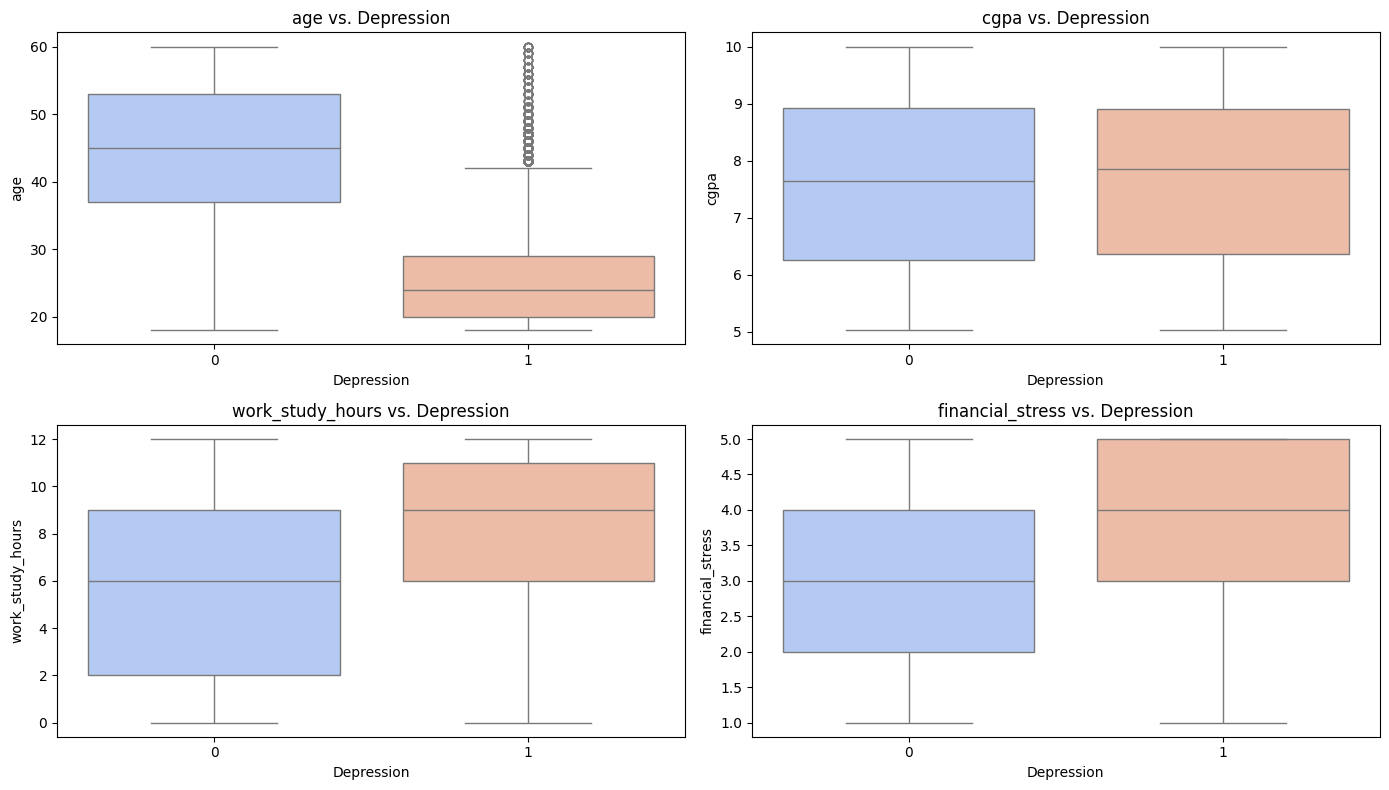

In [25]:
# Box plots to see the relationship between numerical features and Depression
plt.figure(figsize=(14, 8))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='depression', y=col, data=df, hue='depression', palette='coolwarm', legend=False)
    plt.title(f'{col} vs. Depression')
    plt.xlabel('Depression')
    plt.ylabel(col)
plt.tight_layout()
plt.show()


| Feature            | Observed Relationship with Depression (0 = No, 1 = Yes)          | Interpretation / Possible Insight                                |
|--------------------|---------------------------------------------------------------|------------------------------------------------------------------|
| `age`              | Depressed group (1) is younger; median ~22 vs. ~45 for non-depressed | Younger individuals appear more likely to report depression in this sample. Could reflect age-related stress or reporting bias. |
| `cgpa`             | Similar medians; slightly wider spread for depressed group        | No strong relationship; academic performance appears fairly similar between groups. |
| `work_study_hours` | Higher median work/study hours among depressed group              | More work/study hours may be associated with increased depression risk, possibly due to stress or overcommitment. |
| `financial_stress` | Higher median financial stress among depressed group             | Clear relationship: Higher financial stress correlates with higher likelihood of depression. Financial factors likely play a role in well-being. |


# Correlation Matrix of Numerical Features

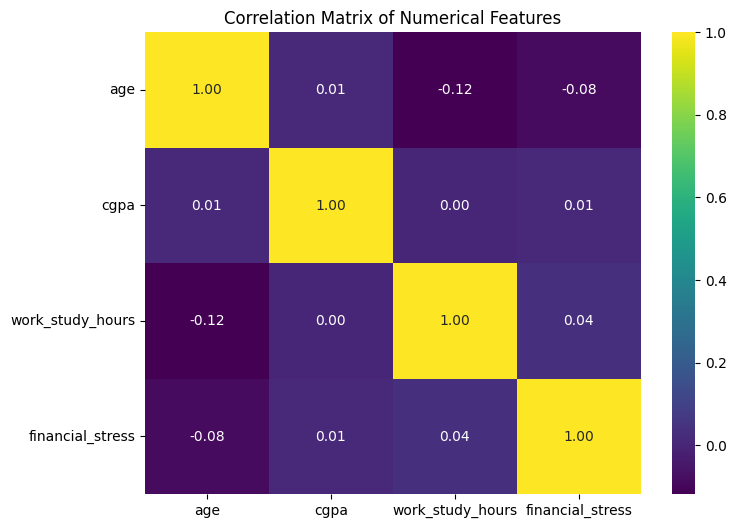

In [26]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

| Pair of Features             | Correlation Coefficient | Interpretation / Possible Insight                               |
|------------------------------|------------------------|---------------------------------------------------------------|
| `age` vs. `cgpa`             | 0.01                   | No meaningful relationship between age and CGPA.               |
| `age` vs. `work_study_hours` | -0.12                  | Weak negative correlation: younger students may work/study more.|
| `age` vs. `financial_stress` | -0.08                  | Very weak negative correlation: younger students may experience slightly more financial stress. |
| `cgpa` vs. `work_study_hours`| 0.00                   | No relationship between CGPA and work/study hours.              |
| `cgpa` vs. `financial_stress`| 0.01                   | No relationship between CGPA and financial stress.              |
| `work_study_hours` vs. `financial_stress` | 0.04    | Very weak positive correlation: slight tendency for students with more work/study hours to have higher financial stress. |


# Categorical Feature Analysis

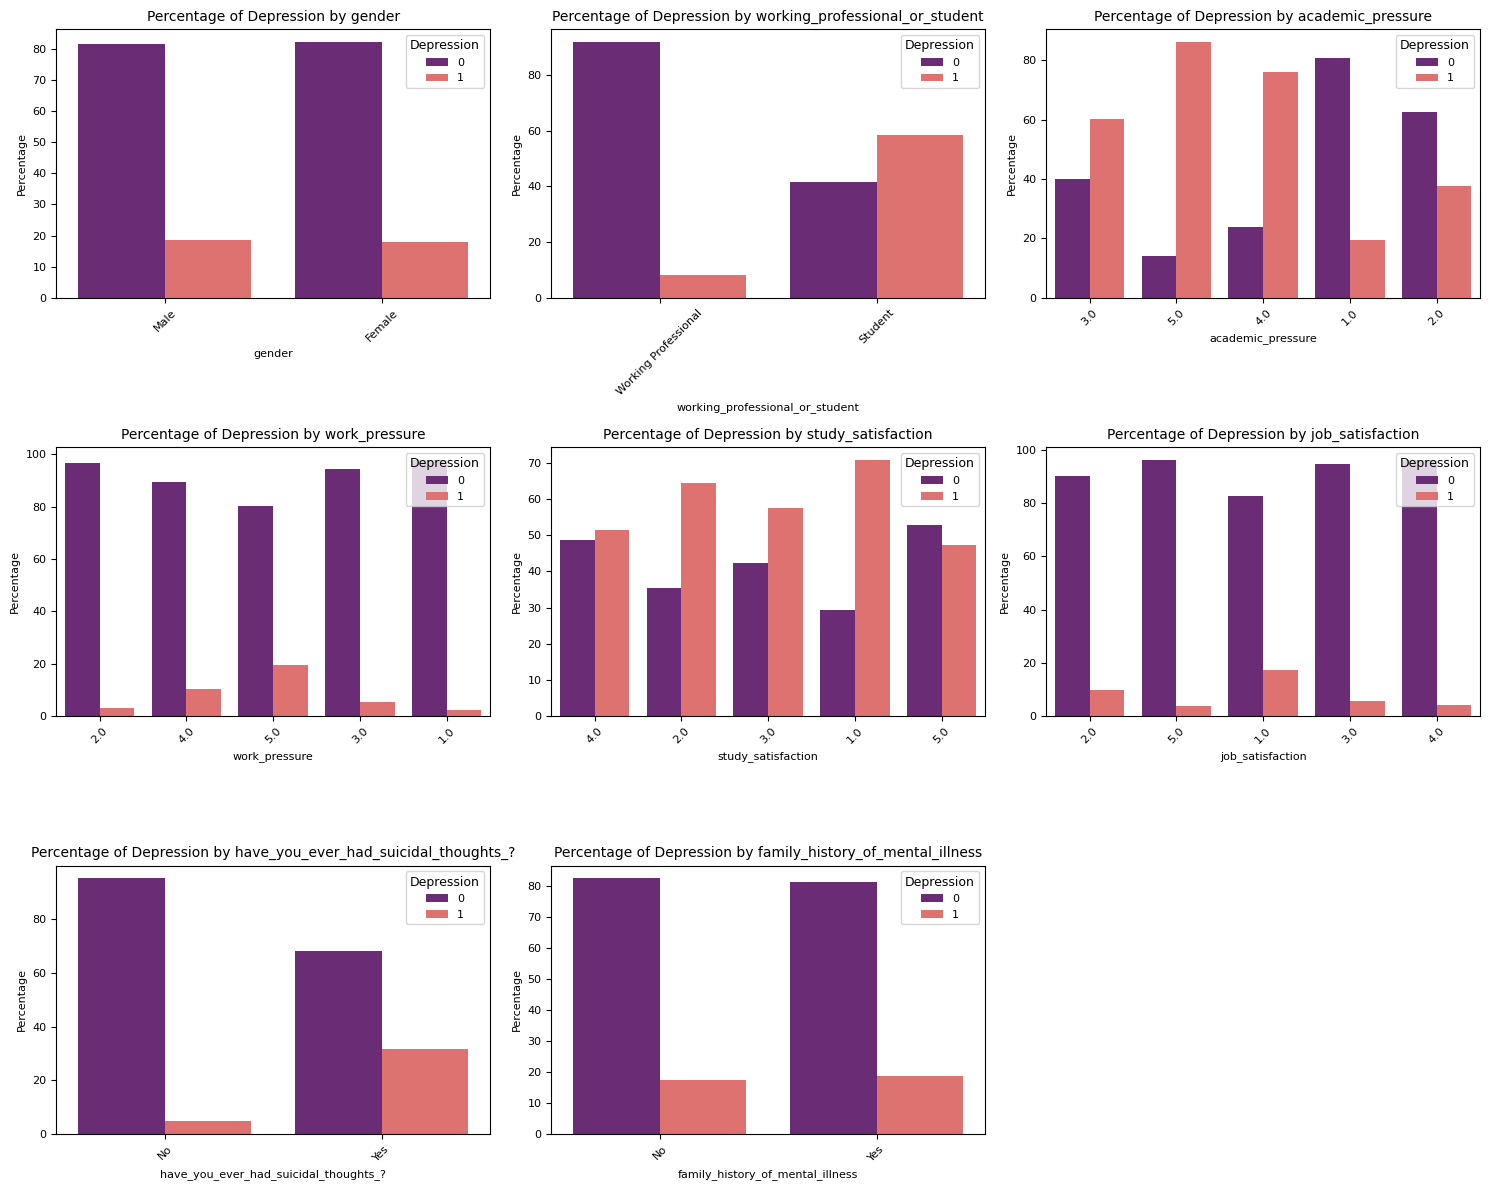

In [27]:
categorical_features = [
    'gender', 'working_professional_or_student', 'academic_pressure',
    'work_pressure', 'study_satisfaction', 'job_satisfaction',
    'sleep_duration', 'dietary_habits', 'have_you_ever_had_suicidal_thoughts_?',
    'family_history_of_mental_illness'
]


def plot_categorical_percentages_grid(df, features, target='depression', cols_per_row=3):
    n_features = len(features)
    n_cols = cols_per_row
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        # Calculate percentage of each target class per category
        percentage_df = df.groupby([feature, target]).size().reset_index(name='count')
        total_df = df.groupby(feature).size().reset_index(name='total')
        percentage_df = percentage_df.merge(total_df, on=feature)
        percentage_df['percentage'] = 100 * percentage_df['count'] / percentage_df['total']

        sns.barplot(ax=axes[i], x=feature, y='percentage', hue=target, data=percentage_df,
                    palette='magma', order=df[feature].value_counts().index)

        axes[i].set_title(f'Percentage of Depression by {feature}', fontsize=10)
        axes[i].set_xlabel(feature, fontsize=8)
        axes[i].set_ylabel('Percentage', fontsize=8)
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i].tick_params(axis='y', labelsize=8)
        axes[i].legend(title='Depression', fontsize=8, title_fontsize=9)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

exclude_features = ['sleep_duration', 'dietary_habits']

filtered_categorical_features = [f for f in categorical_features if f not in exclude_features]

plot_categorical_percentages_grid(df, filtered_categorical_features)

| Feature                               | Observed Relationship with Depression                  | Interpretation / Possible Insight |
|---------------------------------------|-------------------------------------------------------|-----------------------------------|
| gender                                | Very similar depression % for Male and Female          | No strong gender-based difference observed |
| working_professional_or_student       | Students show much higher depression % than professionals | Being a student is associated with higher depression risk |
| academic_pressure                     | Higher academic pressure (5, 4) linked to higher depression % | Strong positive relationship — academic stress appears impactful |
| work_pressure                         | Very low depression % across all work_pressure levels  | Little/no relationship — work pressure may not strongly affect depression in this sample |
| study_satisfaction                    | Lower study satisfaction linked to higher depression % | Inverse relationship — dissatisfaction strongly linked to depression |
| job_satisfaction                      | Lower job satisfaction linked to higher depression %   | Inverse relationship — dissatisfaction correlated with depression |
| have_you_ever_had_suicidal_thoughts_? | "Yes" group shows much higher depression %             | Very strong relationship — suicidal thoughts highly predictive of depression |
| family_history_of_mental_illness      | "Yes" group shows slightly higher depression %         | Family history is a mild risk factor but not as strong as e.g. study/job satisfaction or suicidal thoughts |


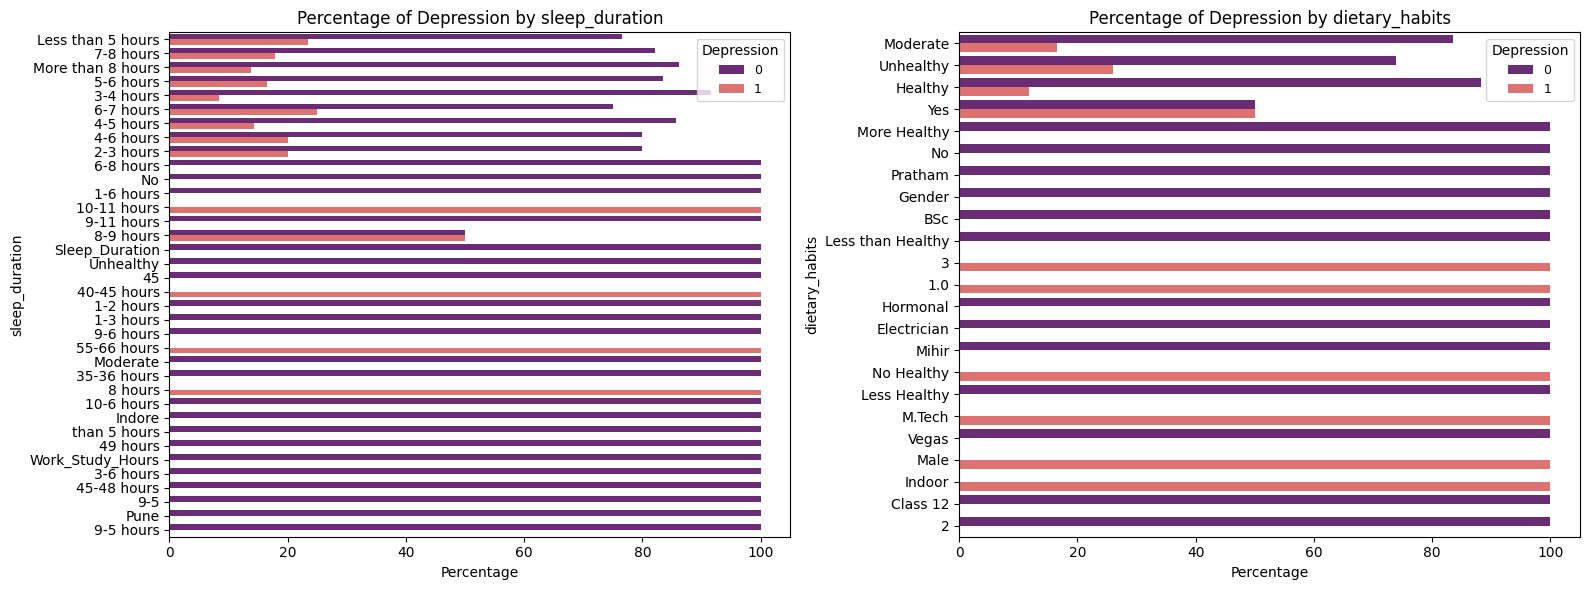

In [28]:
def plot_horizontal_categorical_percentages_side_by_side(df, features, target='depression'):
    n_features = len(features)
    fig, axes = plt.subplots(1, n_features, figsize=(n_features * 8, 6))

    if n_features == 1:
        axes = [axes]

    for i, feature in enumerate(features):
        percentage_df = df.groupby([feature, target]).size().reset_index(name='count')
        total_df = df.groupby(feature).size().reset_index(name='total')
        percentage_df = percentage_df.merge(total_df, on=feature)
        percentage_df['percentage'] = 100 * percentage_df['count'] / percentage_df['total']

        sns.barplot(ax=axes[i], y=feature, x='percentage', hue=target, data=percentage_df,
                    palette='magma', order=df[feature].value_counts().index)

        axes[i].set_title(f'Percentage of Depression by {feature}', fontsize=12)
        axes[i].set_ylabel(feature, fontsize=10)
        axes[i].set_xlabel('Percentage', fontsize=10)
        axes[i].legend(title='Depression', fontsize=9, title_fontsize=10)

    plt.tight_layout()
    plt.show()

plot_horizontal_categorical_percentages_side_by_side(df, ['sleep_duration', 'dietary_habits'])

| Feature         | Observed Relationship with Depression                        | Interpretation / Possible Insight |
|-----------------|-------------------------------------------------------------|-----------------------------------|
| sleep_duration  | - "Less than 5 hours", "5-6 hours", "6-7 hours", "4-5 hours" → higher depression % <br> - Optimal ranges ("7-8 hours", "More than 8 hours") → lower depression % <br> - Many noisy/miscategorized values (e.g. "Work_Study_Hours", "9-5") cluttering plot | **Clear relationship:** Short sleep duration is associated with higher depression % <br> **Data cleaning needed** — multiple inconsistent categories present |
| dietary_habits  | - "Moderate", "Unhealthy", "Healthy" show expected pattern (Unhealthy → higher depression %) <br> - Many noisy/miscategorized values (e.g. "Yes", "No", names, unrelated terms) → these have inconsistent patterns | **General trend:** Unhealthy dietary habits linked to higher depression % <br> **Data cleaning needed** — many irrelevant/mistyped values in `dietary_habits` column |


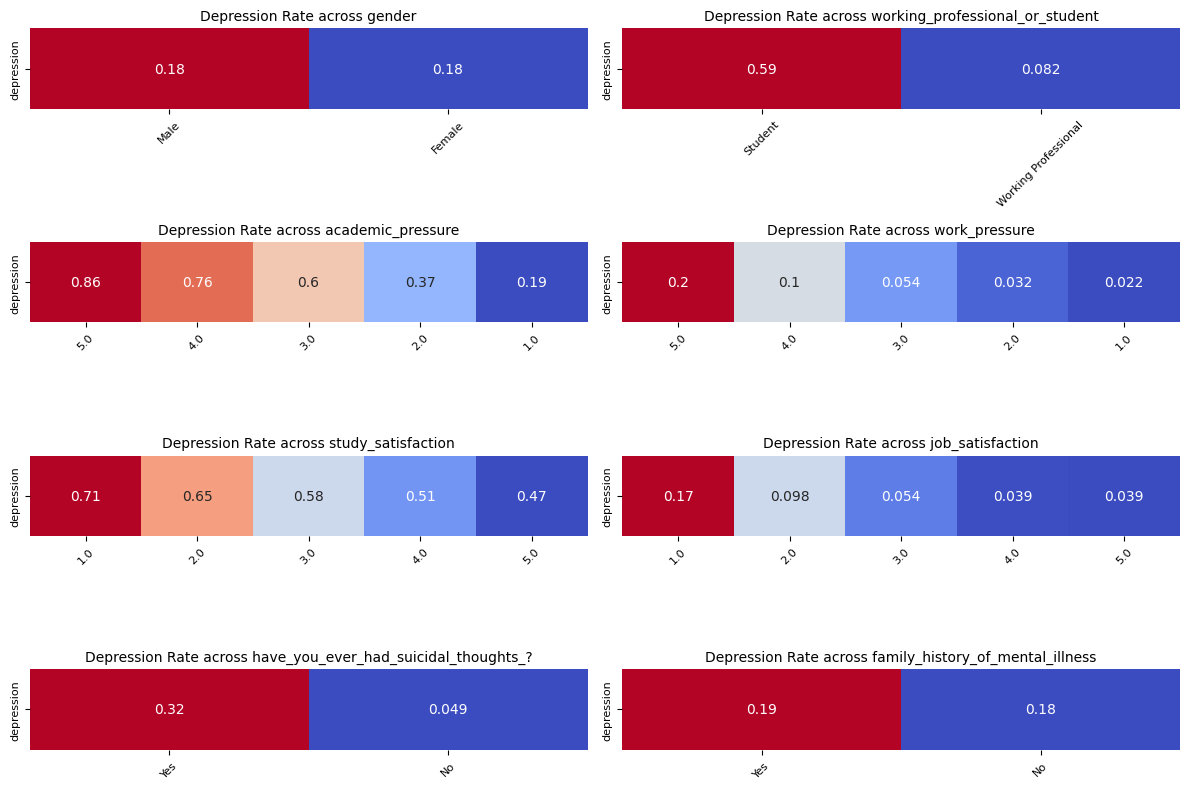

In [29]:
def depression_rate_heatmaps_grid(df, features, target='depression', cols_per_row=2, exclude_features=[]):
    features = [f for f in features if f not in exclude_features]

    n_features = len(features)
    n_cols = cols_per_row
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 2))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        rate_df = df.groupby(feature)[target].mean().reset_index()
        rate_df = rate_df.sort_values(by=target, ascending=False)

        sns.heatmap(rate_df[[target]].T, annot=True, cmap='coolwarm', cbar=False,
                    xticklabels=rate_df[feature], ax=axes[i])

        axes[i].set_title(f'Depression Rate across {feature}', fontsize=10)
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i].tick_params(axis='y', labelsize=8)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

depression_rate_heatmaps_grid(df, categorical_features, exclude_features=['sleep_duration', 'dietary_habits'])

| Feature                               | Observed Relationship with Depression                  | Interpretation / Possible Insight |
|---------------------------------------|-------------------------------------------------------|-----------------------------------|
| gender                                | Same depression rate (~18%) for both Male and Female   | No gender-based difference observed |
| working_professional_or_student       | Students: 59% <br> Working Professionals: 8%           | Being a student strongly linked to higher depression |
| academic_pressure                     | Strong gradient: higher academic pressure → higher depression (86% at level 5 → 19% at level 1) | Academic stress is a major factor for depression |
| work_pressure                         | Depression decreases with lower work pressure <br> Max: 20% (level 5), Min: ~2% (level 1) | Work stress impacts depression but less dramatically than academic pressure |
| study_satisfaction                    | Inverse relationship: lower satisfaction → higher depression <br> 71% at level 1 → 47% at level 5 | Study dissatisfaction is a significant depression risk factor |
| job_satisfaction                      | Similar inverse relationship: lower job satisfaction → higher depression <br> 17% at level 1 → ~4% at level 5 | Job dissatisfaction linked to depression risk |
| have_you_ever_had_suicidal_thoughts_? | "Yes": 32% <br> "No": 4.9%                            | Very strong relationship — suicidal thoughts highly predictive of depression |
| family_history_of_mental_illness      | "Yes": 19% <br> "No": 18%                              | Slight increase in depression with family mental illness history, but not strong in this sample |


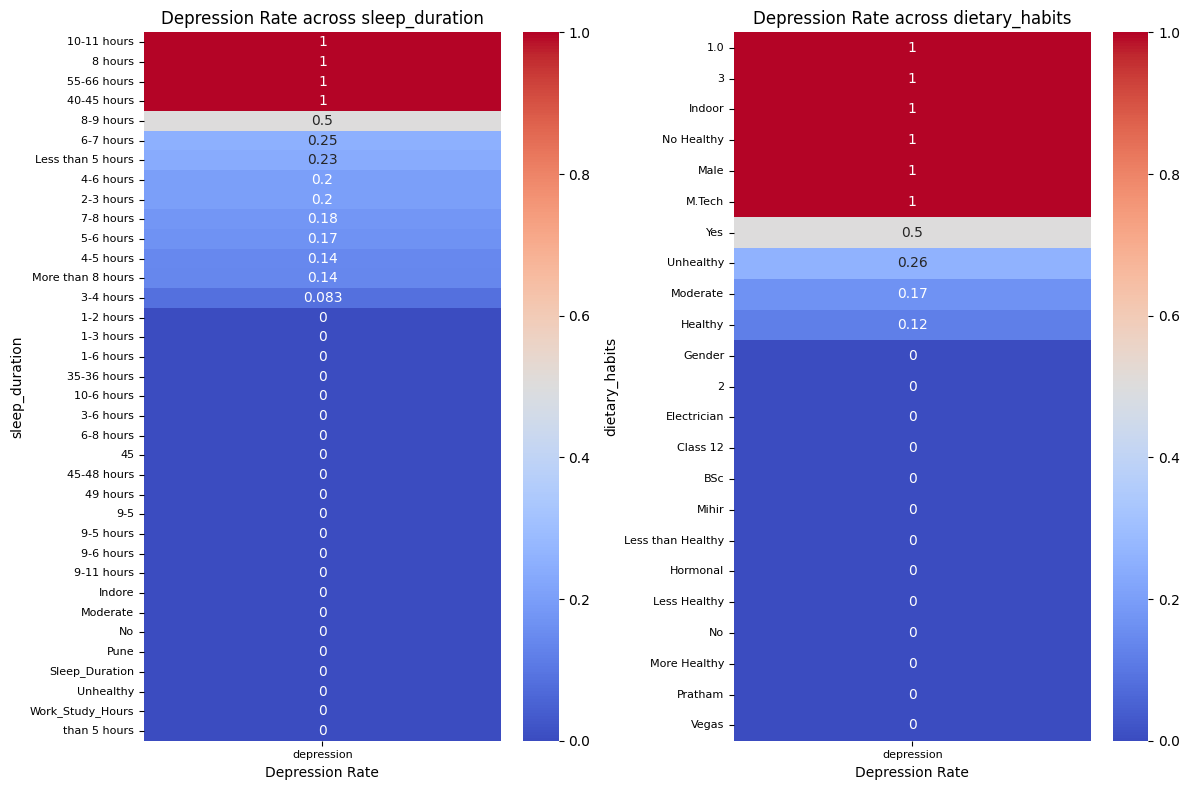

In [30]:
def depression_rate_heatmaps_horizontal(df, features, target='depression'):
    n_features = len(features)
    fig, axes = plt.subplots(1, n_features, figsize=(n_features * 6, 8))

    if n_features == 1:
        axes = [axes]

    for i, feature in enumerate(features):
        rate_df = df.groupby(feature)[target].mean().reset_index()
        rate_df = rate_df.sort_values(by=target, ascending=False)

        sns.heatmap(rate_df.set_index(feature), annot=True, cmap='coolwarm', cbar=True, ax=axes[i])

        axes[i].set_title(f'Depression Rate across {feature}', fontsize=12)
        axes[i].set_xlabel('Depression Rate', fontsize=10)
        axes[i].set_ylabel(feature, fontsize=10)

        axes[i].tick_params(axis='x', rotation=0, labelsize=8)
        axes[i].tick_params(axis='y', rotation=0, labelsize=8)

    plt.tight_layout()
    plt.show()

depression_rate_heatmaps_horizontal(df, ['sleep_duration', 'dietary_habits'])

| Feature         | Observed Relationship with Depression                        | Interpretation / Possible Insight |
|-----------------|-------------------------------------------------------------|-----------------------------------|
| sleep_duration  | - Very short sleep (<= 5-6 hrs) → Higher depression (up to 25%) <br> - Moderate sleep (6-8 hrs) → Lower depression (14-18%) <br> - Long sleep (8-11 hrs) → Some entries show **100% depression**, likely due to small N (warning) <br> - Many noisy values (0 depression) → needs data cleaning | General trend: **short or irregular sleep → higher depression** <br> Long sleep spikes likely artifacts <br> Clean category values to improve signal |
| dietary_habits  | - "Unhealthy" → Higher depression (26%) <br> - "Moderate" → 17% <br> - "Healthy" → 12% <br> - Many irrelevant/noisy values (Gender, Class 12, Vegas, etc) with 0 depression — needs cleaning | **Unhealthy dietary habits are linked to higher depression** <br> Noise in categories should be cleaned to reveal clearer pattern |

In [31]:
# Define target variable
target_variable = 'depression'

# Define potential features (you may need to adjust this list)
# Let's start with a subset of columns that seem relevant and manageable
numerical_features = ['age', 'cgpa', 'work_study_hours', 'financial_stress']
categorical_features = [
    'gender', 'working_professional_or_student', 'academic_pressure',
    'work_pressure', 'study_satisfaction', 'job_satisfaction',
    'sleep_duration', 'dietary_habits', 'have_you_ever_had_suicidal_thoughts_?',
    'family_history_of_mental_illness'
]

# Drop rows where the target variable is missing (if any)
df.dropna(subset=[target_variable], inplace=True)

X = df[numerical_features + categorical_features].copy()
y = df[target_variable]



In [32]:
# Preprocessing steps

# 1. Imputers
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# 2. Encoders/Scalers
# For categorical features: Impute then OneHotEncode
categorical_transformer = ColumnTransformer(
    transformers=[
        ('impute', categorical_imputer, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features) # drop='first' to avoid multicollinearity
    ],
    remainder='passthrough' # Keep other columns (numerical ones in this case)
)

# For numerical features: Impute then Scale
numerical_transformer = ColumnTransformer(
    transformers=[
        ('impute', numerical_imputer, numerical_features),
        ('scaler', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)


# Create a preprocessor object using ColumnTransformer
# This will apply different transformations to different columns

# First, impute missing values for all feature types
X[numerical_features] = numerical_imputer.fit_transform(X[numerical_features])
X[categorical_features] = categorical_imputer.fit_transform(X[categorical_features])


# Now, apply one-hot encoding to categorical features and scaling to numerical features
# We will create a final preprocessor to transform the X data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='drop' # Drop any columns not specified
)

# Apply the preprocessing to X
X_processed = preprocessor.fit_transform(X)

# Get feature names after one-hot encoding for better interpretability if needed
# This can be complex with ColumnTransformer, but here's a way:
try:
    feature_names_out = preprocessor.get_feature_names_out()
    X_processed_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed, columns=feature_names_out)

except Exception as e:
    print(f"\nCould not get feature names out, using X_processed as numpy array. Error: {e}")
    X_processed_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed)


# Encode the target variable 'y' if it's not already 0s and 1s
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (112560, 81)
X_test shape: (28140, 81)
y_train shape: (112560,)
y_test shape: (28140,)


In [34]:

from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training set ONLY
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print shapes to verify
print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")

X_train_resampled shape: (184212, 81)
y_train_resampled shape: (184212,)


In [35]:
# Initialize and train the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train_resampled, y_train_resampled)

print("\nGaussian Naive Bayes model trained successfully.")


Gaussian Naive Bayes model trained successfully.


In [36]:
# Make predictions on the test set
y_pred_gnb = gnb.predict(X_test)
y_pred_proba_gnb = gnb.predict_proba(X_test)[:, 1] # Probabilities for ROC AUC

print("\nPredictions made on the test set.")


Predictions made on the test set.



Accuracy (GaussianNB): 0.1819

Confusion Matrix (GaussianNB):
[[    7 23020]
 [    0  5113]]

Classification Report (GaussianNB):
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     23027
           1       0.18      1.00      0.31      5113

    accuracy                           0.18     28140
   macro avg       0.59      0.50      0.15     28140
weighted avg       0.85      0.18      0.06     28140


ROC AUC Score (GaussianNB): 0.5002


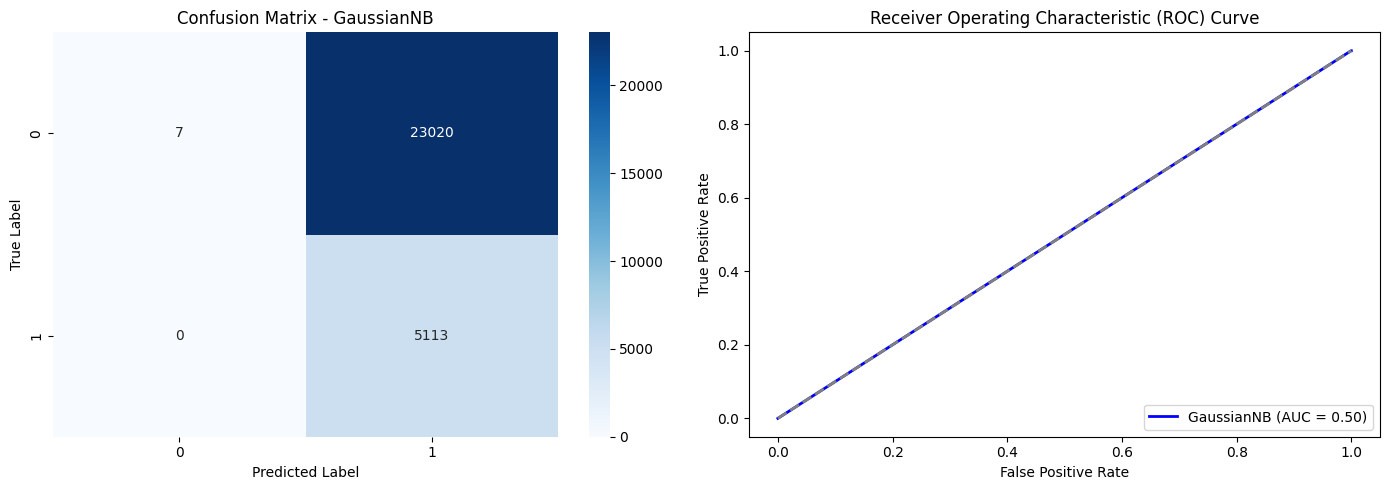

In [37]:
# ---- Overall Accuracy ----
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print("="*50)
print(f"\nAccuracy (GaussianNB): {accuracy_gnb:.4f}")
print("="*50)

# ---- Confusion Matrix ----
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
print("\nConfusion Matrix (GaussianNB):")
print(cm_gnb)

# ---- Classification Report ----
print("="*50)
print("\nClassification Report (GaussianNB):")
print(classification_report(y_test, y_pred_gnb, target_names=[str(c) for c in label_encoder_y.classes_]))
print("="*50)

# ---- ROC AUC ----
roc_auc_gnb = roc_auc_score(y_test, y_pred_proba_gnb)
print(f"\nROC AUC Score (GaussianNB): {roc_auc_gnb:.4f}")
print("="*50)

# ---- Visualization: Confusion Matrix + ROC Curve side by side ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder_y.classes_, yticklabels=label_encoder_y.classes_,
            ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix - GaussianNB')

# ROC Curve
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, y_pred_proba_gnb)
axes[1].plot(fpr_gnb, tpr_gnb, color='blue', lw=2, label=f'GaussianNB (AUC = {roc_auc_gnb:.2f})')
axes[1].plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

| Metric / Result                     | Observation / Value                                    | Interpretation / Possible Insight |
|-------------------------------------|------------------------------------------------------|-----------------------------------|
| Accuracy                            | 0.18                                                 | Very low accuracy; model is misclassifying majority class 0 as class 1 |
| Confusion Matrix (True 0 vs Pred)    | 4 true negatives, 23,023 false positives              | Model is predicting almost all 0s as 1s (major false positive problem) |
| Confusion Matrix (True 1 vs Pred)    | 5,113 true positives, 0 false negatives               | Model is correctly predicting all 1s → recall for class 1 is 1.0 |
| Precision (Class 0)                 | 1.00                                                 | Model predicted a few 0s — all correct, but very few predictions of 0 made |
| Recall (Class 0)                    | 0.00                                                 | Model failed to recall true 0s → massive bias toward predicting 1 |
| F1-Score (Class 0)                  | 0.00                                                 | Model has no ability to correctly predict class 0 |
| Precision (Class 1)                 | 0.18                                                 | Many false positives → low precision for class 1 |
| Recall (Class 1)                    | 1.00                                                 | Model predicts all class 1 correctly → recall is perfect for class 1 |
| F1-Score (Class 1)                  | 0.31                                                 | Low F1-score; imbalance between precision and recall |
| Macro Avg F1-Score                  | 0.15                                                 | Very low overall model balance across both classes |
| Weighted Avg F1-Score               | 0.06                                                 | Even lower when accounting for class imbalance (class 0 dominates) |
| ROC AUC                             | 0.50                                                 | Model is no better than random guessing (ROC AUC ~ 0.50) |
